In [1]:
from z3 import *
import numpy as np
from itertools import product, count
from skimage.morphology import label
from scipy.ndimage import measurements
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Markdown, display
import time
import warnings
from collections import defaultdict
from matplotlib.colors import ListedColormap
warnings.filterwarnings("ignore", message="Please use `label` from the `scipy.ndimage` namespace")
warnings.filterwarnings("ignore", message="Please use `sum` from the `scipy.ndimage` namespace")

In [ ]:
grid = np.array([[  0,  0,  0,  0,  5,  0,  0,  0,  0],
                 [  0,  0,  0,  4,  0,  0,  0,  0,  0],
                 [  0,  0,  0,  0,  0,  0,  0,  0,  0],
                 [  0,  0,  0,  0,  0,  0,  0,  0,  0],
                 [  0,  0,  0,  0,  1,  0,  0,  0,  0],
                 [  0,  0,  0,  0,  0,  0,  0,  0,  0],
                 [  0,  0,  0,  0,  0,  0,  0,  0,  0],
                 [  0,  0,  0,  0,  0,  8,  0,  0,  0],
                 [  0,  0,  0,  0,  9,  0,  0,  0,  0]], dtype=int)

def sol_print(numbers: np.ndarray, hooks: np.ndarray, shapes_dict: dict[str, np.ndarray]) -> None:
    names = list(shapes_dict.keys())
    pent_id   = np.zeros_like(numbers, dtype=int)
    pent_text = np.full(numbers.shape, "", dtype=object)
    for idx, name in enumerate(names, start=1):
        G = shapes_dict[name]
        mask = (G == 1)
        pent_id[mask] = idx
        pent_text[mask] = name

    used = [name for name in names if np.any(shapes_dict[name] == 1)]
    _, axs = plt.subplots(1, 2, figsize=(14, 7))

    x = numbers.astype(int).astype(str)
    x[x == "0"] = "-"
    sns.heatmap(hooks, annot=x, cbar=False, cmap="tab10", fmt="",
                linewidths=0.25, annot_kws={"fontsize": 12}, ax=axs[0])
    axs[0].set_xticks([]); axs[0].set_yticks([])
    axs[0].set_title("Hooks + Numbers")

    base = plt.get_cmap("tab20").colors
    colors = [(0.92, 0.92, 0.92)] + list(base[:max(1, len(names))])
    cmap = ListedColormap(colors)
    sns.heatmap(pent_id, annot=pent_text, cbar=False, cmap=cmap, fmt="",
                linewidths=0.25, annot_kws={"fontsize": 12}, ax=axs[1])
    axs[1].set_xticks([]); axs[1].set_yticks([])
    axs[1].set_title("Pentomino Map")

    handles = [plt.Line2D([0],[0], marker='s', linestyle='',
                          color=colors[i], markersize=12, label=names[i-1])
               for i in range(1, len(names)+1)]
    if handles:
        axs[1].legend(handles=handles, bbox_to_anchor=(1.02, 1), loc="upper left", frameon=False)

    plt.tight_layout()
    plt.show()
    display(Markdown("**Pentominoes used:** " + (", ".join(used) if used else "_none_")))


def areas(grid: np.ndarray) -> int:
    labels, num = measurements.label(np.logical_not(grid!=0))
    areas = measurements.sum(np.logical_not(grid>=1), labels, index=range(1, num+1))
    return int(np.prod(areas))

In [3]:
def make_hooks(n: int) -> np.ndarray:
    matrix = np.ones((n, n), dtype=int) * (2*n -1)
    matrix[1:,1:] = 0
    return [np.rot90(matrix, i) for i in range(4)]

hook_17, hook_15, hook_13, hook_11, hook_9, hook_7, hook_5, hook_3 = \
    make_hooks(9), make_hooks(8), make_hooks(7), make_hooks(6), make_hooks(5), make_hooks(4), make_hooks(3), make_hooks(2)
    
orthagonal = lambda i, j, N: [(i+di, j+dj) for (di,dj) in [(0,1),(1,0),(0,-1),(-1,0)] if 0<=i+di<N and 0<=j+dj<N]

def hook_constraint(hook_number: int, board: np.ndarray, N: int) -> PbEq:
    hook = dict[int, list]({17: hook_17, 15: hook_15, 13: hook_13, 11: hook_11, 9: hook_9, 7: hook_7, 5: hook_5, 3: hook_3}).get(hook_number)
    shift = N+1 - (hook_number + 1) // 2
    conditions = list[And]()
    for shift_i, shift_j, h in product(range(shift), range(shift), hook):
        conditions.append(And([board[i+shift_i][j+shift_j]==e for (i,j),e in np.ndenumerate(h) if e]))
    return PbEq([(cond, 1) for cond in conditions], 1)

In [ ]:
def norm(coords) -> list[tuple[int,int]]:
    mr = min(r for r,c in coords); mc = min(c for r,c in coords)
    return [(r - mr, c - mc) for r,c in coords]

def rot90(coords) -> list[tuple[int,int]]:
    R = max(r for r,c in coords)
    return norm([(c, R - r) for r,c in coords])

def mirror_v(coords) -> list[tuple[int,int]]:
    C = max(c for r,c in coords)
    return norm([(r, C - c) for r,c in coords])

def orientations(base, include_mirror=True) -> list[list[tuple[int,int]]]:
    seeds = [base, mirror_v(base)] if include_mirror else [base]
    seen = set()
    out = []
    for seed in seeds:
        shp = norm(seed)
        for _ in range(4):
            key = frozenset(shp)
            if key not in seen:
                seen.add(key)
                out.append(list(shp))
            shp = rot90(shp)
    return out

def enumerate_placements(N, rel):
    H = max(r for r,_ in rel) + 1
    W = max(c for _,c in rel) + 1
    for a,b in product(range(N - H + 1), range(N - W + 1)):
        yield [(a + r, b + c) for r, c in rel]

def add_shape(s, symbol, base, N, must_hit=None, include_mirror=True):
    pls = [cells for rel in orientations(base, include_mirror=include_mirror)
                 for cells in enumerate_placements(N, rel)
                 if (must_hit is None or must_hit(cells))]
    if not pls:
        raise ValueError(f"{symbol}: no placements")
    P = np.array(BoolVector(f"{symbol}_placements", len(pls)), dtype=object)
    s += [PbEq([(p,1) for p in P], 1)]
    buck = defaultdict(list)
    [buck[(i,j)].append(P[k]) for k,cells in enumerate(pls) for (i,j) in cells]
    covered = np.array([[Or(*buck[(i,j)]) if buck[(i,j)] else BoolVal(False)
                         for j in range(N)] for i in range(N)], dtype=object)
    return covered, P, pls

def add_shape_optional(s, symbol, base, N, must_hit=None, include_mirror=True):
    pls = [cells for rel in orientations(base, include_mirror=include_mirror)
                 for cells in enumerate_placements(N, rel)
                 if (must_hit is None or must_hit(cells))]
    if not pls: raise ValueError(f"{symbol}: no placements")
    P = np.array(BoolVector(f"{symbol}_placements", len(pls)), dtype=object)
    placed = P[0] if len(P)==1 else Or(*P)
    if len(P) >= 2: s += [PbLe([(p,1) for p in P], 1)]
    buck = defaultdict(list)
    [buck[(i,j)].append(P[k]) for k,cells in enumerate(pls) for (i,j) in cells]
    covered = np.array([[Or(*buck[(i,j)]) if buck[(i,j)] else BoolVal(False)
                         for j in range(N)] for i in range(N)], dtype=object)
    return covered, P, placed, pls

def first_shape_in_row(s, row, direction, target_grid, N, X):
    if direction == "L":
        s += [Or(*[And(*[X[row][j] == 0 for j in range(k)], target_grid[row][k]) for k in range(5)])]
    else:
        s += [Or(*[And(*[X[row][j] == 0 for j in range(k+1, N)], target_grid[row][k]) for k in range(3,N)])]
        
def eval_bool_grid(m, G, N):
    return np.array([[1 if is_true(m.evaluate(G[i][j])) else 0 for j in range(N)] for i in range(N)], dtype=int)

## Total solve time of 24.917 seconds

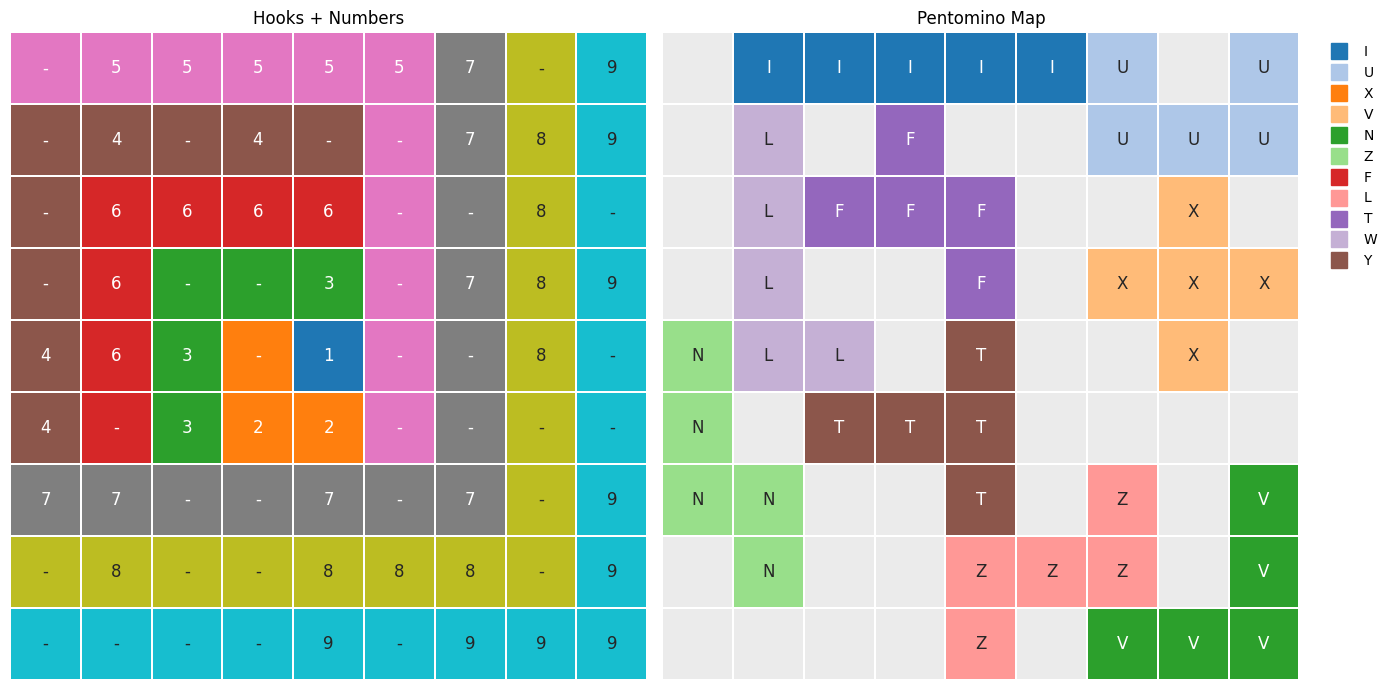

**Pentominoes used:** I, U, X, V, N, Z, F, L, T

## Answer is: 1,620

In [ ]:
start = time.time()
s = Solver()
N = 9
X = np.array(IntVector("X", N**2), dtype=object).reshape((N, N))
Y = np.array(IntVector("Y", N**2), dtype=object).reshape((N, N))


I_base = [(0,0),(0,1),(0,2),(0,3),(0,4)]
I, iP, i_pls = add_shape(
    s, "I", I_base, N,
    must_hit=lambda cells: any(i==0 for i,_ in cells) and all(j<N-3 for _,j in cells),
    include_mirror=False
)

U_base = [(0,0),(0,1),(0,2),(1,0),(1,2)]
U, uP, u_pls = add_shape(
    s, "U", U_base, N,
    must_hit=lambda cells: all(j>=2 for _,j in cells) and any(i==0 for i,_ in cells)
)

X_base = [(1,1),(0,1),(1,0),(1,2),(2,1)]
Xpent, xP, x_pls = add_shape(
    s, "Xpent", X_base, N,
    must_hit=lambda cells: any(i==3 for i,_ in cells) and all(j>=2 for _,j in cells),
    include_mirror=False
)

N_base = [(0,0),(0,1),(0,2),(1,2),(1,3)]
Nshape, nP, n_pls = add_shape(
    s, "Nshape", N_base, N,
    must_hit=lambda cells: any(i==5 for i,_ in cells) and not any(j>N-3 for _,j in cells)
)

Z_base = [(0,0),(0,1),(1,1),(2,1),(2,2)]
Zshape, zP, z_pls = add_shape(
    s, "Zshape", Z_base, N,
    must_hit=lambda cells: any(i==8 for i,_ in cells),
    include_mirror=False
)

V_base = [(0,0),(1,0),(2,0),(2,1),(2,2)]
V, vP, v_pls = add_shape(
    s, "V", V_base, N,
    must_hit=lambda cells: all(j>=4 for _,j in cells) and any(i==8 for i,_ in cells)
)

# F, L, P, T, W, Y but NOT P
F_base = [(0,1),(0,2),(1,0),(1,1),(2,1)]
L_base = [(0,0),(1,0),(2,0),(3,0),(3,1)]
T_base = [(0,0),(0,1),(0,2),(1,1),(2,1)]
W_base = [(0,0),(1,0),(1,1),(2,1),(2,2)]
Y_base = [(0,1),(1,0),(1,1),(1,2),(1,3)]

F, fP, f_used, _ = add_shape_optional(s, "F", F_base, N)
L, lP, l_used, _ = add_shape_optional(s, "L", L_base, N)
Tt, tP, t_used, _ = add_shape_optional(s, "Tt", T_base, N, include_mirror=False)
Ww, wP, w_used, _ = add_shape_optional(s, "Ww", W_base, N)
Yy, yP, y_used, _ = add_shape_optional(s, "Yy", Y_base, N)

second_6   = [F, L, Tt, Ww, Yy]
second_use = [f_used, l_used, t_used, w_used, y_used]
all_shapes = [I, U, Xpent, V, Nshape, Zshape] + second_6

s += [Sum([If(b,1,0) for b in second_use]) == 3]

for i, j in product(range(N), repeat=2):
    lits = [(G[i][j], 1) for G in all_shapes if not is_false(G[i][j])]
    if len(lits) >= 2:
        s += [PbLe(lits, 1)]

for i, j in product(range(N), repeat=2):
    terms = [If(G[i][j], 1, 0) for G in all_shapes if not is_false(G[i][j])]
    covered = Sum(terms) if terms else 0
    s += [If(X[i][j] > 0, 1, 0) == covered]
    
    
# ============================================================================================

first_shape_in_row(s, row=0, direction="L", target_grid=I, N=N, X=X)
first_shape_in_row(s, row=0, direction="R", target_grid=U, N=N, X=X)
first_shape_in_row(s, row=3, direction="R", target_grid=Xpent, N=N, X=X)
first_shape_in_row(s, row=5, direction="L", target_grid=Nshape, N=N, X=X)
first_shape_in_row(s, row=8, direction="L", target_grid=Zshape, N=N, X=X)
first_shape_in_row(s, row=8, direction="R", target_grid=V, N=N, X=X)


# ============================================================================================

for name, G, mandatory in [
    ("I", I, True), ("U", U, True), ("Xpent", Xpent, True),
    ("V", V, True), ("Nshape", Nshape, True), ("Zshape", Zshape, True),
    ("F", F, False), ("L", L, False),
    ("Tt", Tt, False), ("Ww", Ww, False), ("Yy", Yy, False),
]:
    total = Sum([If(G[i][j], X[i][j], 0) for (i,j),_ in np.ndenumerate(G)])
    k = Int(f"{name}_sum5")
    s += [total == 5*k, k <= 9, k >= (3 if mandatory else 0)]


# ============================================================================================

s += [Or(*(And(*(X[5][k] == 0 for k in range(j+1, N)),  X[5][j]==2) for j in range(3,6)))]
s += [X[5][6]==0, X[5][7]==0, X[5][8]==0]
s += [Y[5][4]==3]
s += [Or(*(And(*(X[k][2]==0 for k in range(i+1,N)), X[i][2]==3) for i in range(3,7)))]
s += [Or(*(And(*(X[k][6]==0 for k in range(i)), X[i][6]==7) for i in range(6)))]
s += [Or(*(And(*(X[3][k] == 0 for k in range(j)),  X[3][j]==6) for j in range(6)))]

# ============================================================================================


s += [X[i][j]==e for (i,j),e in np.ndenumerate(grid) if e!=0]
s += [And(val >= 0, val <= 9) for val in X.ravel()]
s += [And(val >= 1, val <= 17) for val in Y.ravel()]
s += Or([val==1 for val in Y.ravel()])
s += [PbEq([(X[i][j] == n, 1) for (i,j),_ in np.ndenumerate(X)], n) for n in range(1, N+1)]
s += [Implies(X[i][j]!=0, Or([X[ni][nj]!=0 for (ni,nj) in orthagonal(i, j, N)])) for (i,j),_ in np.ndenumerate(X)]
s += [Or(*(X[i+di][j+dj] == 0 for di in (0,1) for dj in (0,1))) for i,j in product(range(N-1), repeat=2)]

for hook_number in [17, 15, 13, 11, 9, 7, 5, 3]:
    s += hook_constraint(hook_number=hook_number, board=Y, N=N)

s += [Implies(Y[i][j]==1, X[i][j]==1) for (i,j),_ in np.ndenumerate(grid)]
s += [Implies(Y[i][j]>3, X[i][j]!=2) for (i,j),_ in np.ndenumerate(grid)]
s += [X[i][j]<=Y[i][j] for (i,j),_ in np.ndenumerate(grid)]

X17, X15, X13, X11, X9, X7, X5 = Ints("x17 x15 x13 x11 x9 x7 x5")
s += Distinct([X17, X15, X13, X11, X9, X7, X5])
y_to_x_mapping = dict[int, list]({17: X17, 15: X15, 13: X13, 11: X11, 9: X9, 7: X7, 5: X5})
for y_value, x_variable in y_to_x_mapping.items():
    s += [Implies(Y[i][j]==y_value, Or(X[i][j]==x_variable, X[i][j] == 0)) for (i,j),_ in np.ndenumerate(Y)]
    
    
while True:
    if s.check() == sat:
        m = s.model()
        evalu = np.vectorize(lambda x: m.evaluate(x).as_long())
        result_x = evalu(X)

        shapes_dict = {}
        for name, var in [("I","I"),("U","U"),("X","Xpent"),("V","V"),("N","Nshape"),("Z","Zshape"),
                        ("F","F"),("L","L"),("P","Pp"),("T","Tt"),("W","Ww"),("Y","Yy")]:
            if name == "X": pass
            try:
                arr = eval(var)
                shapes_dict[name] = eval_bool_grid(m, arr, N)
            except NameError:
                pass

        if np.max(label(result_x != 0, connectivity=1)) == 1:
            display(Markdown('## Total solve time of {:.3f} seconds'.format(time.time()-start)))
            sol_print(numbers=result_x, hooks=evalu(Y), shapes_dict=shapes_dict)
            display(Markdown('## Answer is: {:,.0f}'.format((areas(result_x)))))
            break
        else:
            s += Or([X[i][j] != int(result_x[i][j]) for i, j in product(range(N), repeat=2)])